<h1><b>TESTS</b>
</h1>

<b>MSE (Mean Square Error)</b>
<br>
The lower, the better. Indicates the amount of noise contained within a picture.
<br>
<br>
$ MSE = \frac{\sum_{m,n} [I_1(m,n)-I_2(m,n)]^{2}}{M \cdot N} $ 
<br>
<br>
<br>
<b>PSNR (Peak Signal to Noise Ratio)</b>
<br>
The higher, the better. Indicates the maximum amount of noise relative to the picture.
<br>
<br>
$ PSNR = 10\log_{10} \left(\frac{R^2}{MSE}\right) $ 

In [1]:
# MSE
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error, variation_of_information
# import imquality.brisque as brisque
from FFT_stego import convert, stego_path_generator


# cover_img_path = "ImageSources\\jfif\\darth_vader.jfif"
# cover_img_path = "ImageSources\\jfif\\the_rock.jfif"
# cover_img_path = "ImageSources\\jfif\\obi-wan_kenobi.jfif"
# PATH = "ImageSources\\png\\r2d2.png"
# cover_img_path = "ImageSources\\jpg\\iron_patriot.jpg"
cover_img_path = "ImageSources\\tif\\lena_color_512.tif"
# stego_img_path = "ImageSources\\Steganograms\\remerged_sharp.png"
# stego_img_path = "Steganograms\\lena_color_512_steg.png"
stego_img_path = "Steganograms\\lena_color_512_steg.tif"

# stego_img_path = stego_path_generator(cover_img_path, "png")

# takes into account the error that occurs when transforming the channel to the frequency domain
def fft_correction(channel, clip: bool=False):
    fft = np.fft.fft2(channel)
    ifft = np.fft.ifft2(np.abs(fft)*np.exp(1j*np.angle(fft))).real
    if clip:
        converted = np.clip(ifft, 0,255).astype(np.uint8)
    else:
        converted = convert(ifft, 0,255, np.uint8)
    return converted


def test(cover_img_path, stego_img_path, channel: int=1, colorspace: str="RGB"):
    image0 = Image.open(cover_img_path).convert(colorspace)
    image1 = Image.open(stego_img_path).convert(colorspace)
    cover_channel = image0.getchannel(channel)
    stego_channel = image1.getchannel(channel)

    # score_c = brisque.score(cover_channel)
    # score_s = brisque.score(stego_channel)
    # print(score_c, score_s)
    cover_channel = np.array(cover_channel)
    stego_channel = np.array(stego_channel)
    ssim = structural_similarity(cover_channel, stego_channel, gaussian_weights=True)

    size = cover_channel.shape

    # mse = np.divide(np.sum(np.square(np.subtract(cover_channel, stego_channel))), np.multiply(*(size)))
    mse = mean_squared_error(cover_channel, stego_channel)

    # psnr = 20*np.log10(255) - 10*np.log10(mse)
    psnr = peak_signal_noise_ratio(cover_channel, stego_channel)

    # voi = variation_of_information(cover_channel, stego_channel)
    return mse, psnr, ssim


mse, psnr, ssim= test(cover_img_path, stego_img_path)

print("MSE = ", mse)
print("PSNR =", psnr, "db")
print("SSIM =", ssim)

MSE =  96.809326171875
PSNR = 28.271631635813932 db
SSIM = 0.872544367551432


<h2>CROP</h2>

(256, 256)


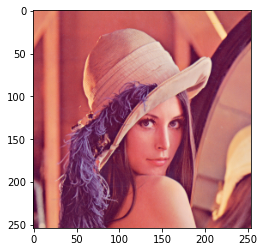

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
from FFT_stego import crop_path_generator, stego_path_generator

# cover_img_path = "ImageSources\\jpg\\lena_color_256.tif"
# stego_img_path = stego_path_generator(cover_img_path, "png")
stego_img_path = "ImageSources\\Steganograms\\lena_color_256_steg.png"

image = Image.open(stego_img_path)
size = image.size
print(size)

crop = 0.01  # crop 50%
crop /= 2

# left, up , right, bottom
# crop the image
cropped = image.crop((round(size[0]*crop),round(size[1]*crop), round(size[0]*(1-crop)),round(size[1]*(1-crop))))

# generates the path for the stego image from the name of the cover image and the path the current python file resides on

crop_img_path = crop_path_generator(stego_img_path, "png")
plt.figure()
plt.imshow(cropped)


cropped.save(crop_img_path)

<h2>Resize</h2>

In [7]:
from PIL import Image
from FFT_stego import resize_path_generator
import numpy as np

# stego_img_path = "ImageSources\\Steganograms\\lena_color_256_steg.png"
# # stego_img_path = "ImageSources\\Steganograms\\lena_color_256_steg_resize.png"

# steg = Image.open(stego_img_path)
# cols, rows = steg.size

# grow_factor = 0.1
# steg_resize = steg.resize((round(rows/grow_factor), round(cols/grow_factor)))

# resize_img_path = resize_path_generator(stego_img_path, "png")
# steg_resize.save(resize_img_path)

# cover_img_path = "ImageSources\\Steganograms\\lena_color_256_steg_resize.png"
# cover_img_path = "C:\\Users\\maxik\\Pictures\\BlueStacks\\IMG_20220109_222259.jpg"
cover_img_path = "ImageSources\\jpg\\iron_patriot.jpg"

steg = Image.open(cover_img_path)
cols, rows = steg.size

ratio = cols/rows

print("original rows, cols: ", rows, cols)
print("ratio: ", ratio)

# check if it is a wider ratio than 16/9 and if so, the columns have to be adjusted since they will be the maximum size (1600)
if ratio >= 16/9:
    if cols > 1600:
        new_cols = 1600
        new_rows = new_cols//ratio
else:
    if rows > 900:
        new_rows = 900
        new_cols = np.round(new_rows*ratio, decimals=0)

print("resized rows, cols: ", new_rows, new_cols)
steg_resize = steg.resize((round(new_cols), round(new_rows)))

resize_img_path = resize_path_generator(cover_img_path, "png")
steg_resize.save(resize_img_path)

original rows, cols:  1080 1920
ratio:  1.7777777777777777
resized rows, cols:  900.0 1600


<h2>Rotate</h2>

In [25]:
from PIL import Image
from FFT_stego import rotate_path_generator

stego_img_path = "ImageSources\\Steganograms\\lena_color_256_steg.png"
#read the image
im = Image.open(stego_img_path)

#rotate image
angle = 45
out = im.rotate(angle)
# out = im.rotate(angle, expand=True)

stego_img_path = rotate_path_generator(stego_img_path, "png")
out.save(stego_img_path)

<h2>Decoder</h2>

In [34]:
from FFT_stego import steg_decode_simple

# stego_img_path = "ImageSources\\Steganograms\\lena_color_256_steg.png"
stego_img_path = "ImageSources\\Steganograms\\remerged_sharp.png"

parsed_text = steg_decode_simple(stego_img_path, cut=0.18768376411533313,colorspace="YCbCr")
print(parsed_text)

Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam🖐


<h2>Absolute FFT</h2>

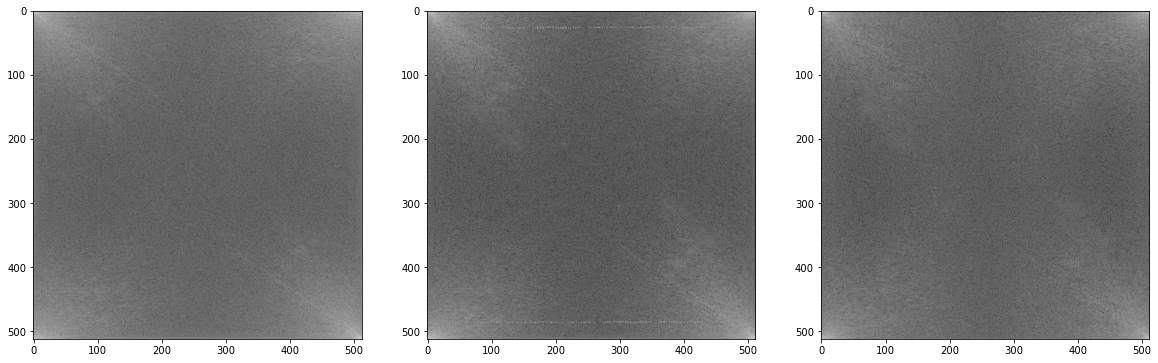

In [27]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

img_path = "Steganograms\\lena_color_512_steg.png"
# img_path = "ImageSources\\Steganograms\\remerged_sharp.png"

image = Image.open(img_path)
channel0, channel1, channel2 = image.split()

fft_abs0 = 10*np.log10(np.abs(np.fft.fft2(channel0)))
fft_abs1 = 10*np.log10(np.abs(np.fft.fft2(channel1)))
fft_abs2 = 10*np.log10(np.abs(np.fft.fft2(channel2)))

plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(fft_abs0, cmap="gray")
plt.subplot(132)
plt.imshow(fft_abs1, cmap="gray")
plt.subplot(133)
plt.imshow(fft_abs2, cmap="gray")

<h2>Show all 3 channels<h2>

image size:  (512, 512)


Text(0.5, 1.0, 'Blue')

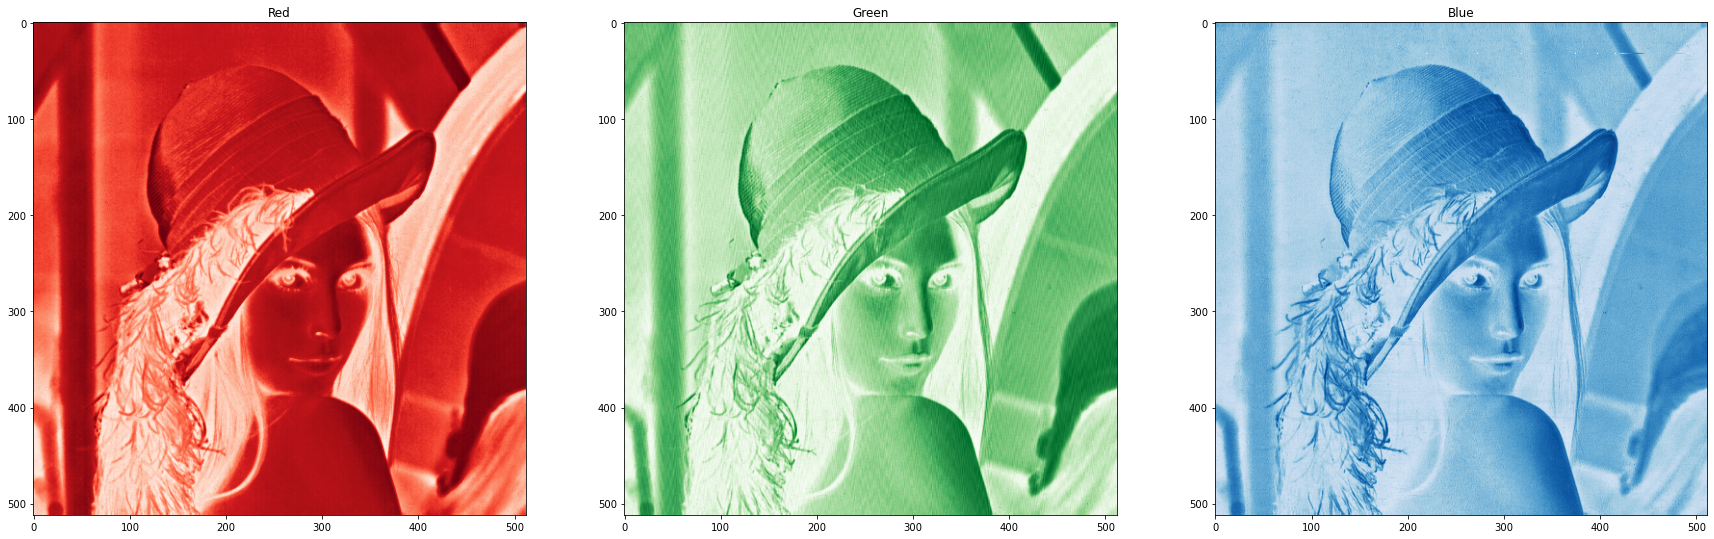

In [21]:
img_path = "Steganograms\\lena_color_512_steg.png"

image = Image.open(img_path)
channel0, channel1, channel2 = image.split()

print("image size: ",image.size)

plt.figure(figsize=(30,30))
plt.subplot(131)
plt.imshow(channel0, cmap="Reds")
plt.title("Red")
plt.subplot(132)
plt.imshow(channel1, cmap="Greens")
plt.title("Green")
plt.subplot(133)
plt.imshow(channel2, cmap="Blues")
plt.title("Blue")

In [16]:
from cryptography.fernet import Fernet

# text = '0.1684086173636722'
cut = 0.1684086173636722
print("{}".format(cut))
text = "{}".format(cut)

def encrypt(message: bytes, key: bytes) -> bytes:
    return Fernet(key).encrypt(message)

def decrypt(token: bytes, key: bytes) -> bytes:
    return Fernet(key).decrypt(token)

def generate_key() -> bytes:
    key = Fernet.generate_key()
    return key

key = generate_key()
token = encrypt(text.encode(), key)
decrypted = decrypt(token, key).decode()

print(text)
print(token)
print(decrypted)


# str = hashlib.sha256(text.encode('utf-8'))
# text_hashed = str.hexdigest()
# print(text_hashed)

0.1684086173636722
0.1684086173636722
b'gAAAAABh3fawZNoUngXADyLiROHs3DXWO2lF9u3wajm4svbVJ7RzIlmxXgBg-emGAWwUmdkKpuFRuc25QABHzsH2oplIpbsKSRyUFIhy3yNuZ_pDLq_zbrc='
0.1684086173636722


<h1>Automated test</h1>

<div>
Test fft gain finder process by <b>altering</b> 
<ul>
    <li>recursion</li>
    <li>cut</li>
    <li>image size</li>
    <li>payload</li>
    <li>image type</li>
</ul>
<ul>
    <li>increase recursion from 0 to 10</li>
    <li>increase max cut from 0.05 to 0.95</li>
    <li>increase image size from 256 to 512</li>
    <li>increase payload from 8 to 100000 bits</li>
    <li>change image type from .png to .tif</li>
</ul>
</div>

In [10]:
from FFT_stego import *
from PIL import Image
from tabulate import tabulate

cover_img_path = "ImageSources\\tif\\mandril_color.tif"
# cover_img_path = "ImageSources\\tif\\lena_color_512.tif"
# cover_img_path = "ImageSources\\jpg\\iron_patriot.jpg"
stego_img_path = stego_path_generator(cover_img_path, "tif")
message = "At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet."

def mprint(metrics: list, meas: str="measured quantity"):
    print(tabulate(metrics, headers=[meas, "MSE", "PSNR", "SSIM", "CUT", "GAIN"]))


# resize test
def resize_test(multiply: int):
    table = []
    for factor in range(1,multiply+1):
        cover_img = Image.open(cover_img_path)
        size = cover_img.size
        cover_img = cover_img.resize((round(size[0]*factor/2), round(size[1]*factor/2)))
        # overwrite cover_img_path
        c_img_path = resize_path_generator(cover_img_path, "tif")
        cover_img.save(c_img_path)
        s_img_path = stego_path_generator(c_img_path, "tif")

        set_maxcut(0.4)
        cut, gain = steg_encode_simple(c_img_path, message, optcut=False, staticgain=100000, imagetype="tif")
        metrics = test(c_img_path, s_img_path)

        # print("image size:",(round(size[0]*factor), round(size[1]*factor)))
        mylist = [(round(size[0]*factor/2), round(size[1]*factor/2))] + [jj for jj in metrics] + [cut, gain]
        table.append(mylist)
    mprint(table, "size")
    print(c_img_path, s_img_path)

# resursion test
def recursion_test(count):
    table = []
    for ii in range(count):
        cut, gain = steg_encode_simple(cover_img_path, message, recursive_cnt=ii, imagetype="tif")
        metrics = test(cover_img_path, stego_img_path)

        mylist = [ii] + [jj for jj in metrics] + [cut, gain]
        table.append(mylist)
    mprint(table, "recursion count")

# payload test
def payload_test(factor):
    table = []
    for ii in range(1,factor):
        try:
            cut, gain = steg_encode_simple(cover_img_path, message*ii, optcut=True, imagetype="tif", recursive_cnt=5)
        except Exception:
            break
        metrics = test(cover_img_path, stego_img_path)
        mylist = [ii*len(message)] + [jj for jj in metrics] + [cut, gain]
        table.append(mylist)
    mprint(table, "message length")


# cut test
def cut_test(res):
    table = []
    for ii in range(res):
        set_maxcut(ii/res)
        if ii == 0:
            set_maxcut(0.2)
            cut, gain = steg_encode_simple(cover_img_path, message, staticgain=100000, optcut=True, imagetype="tif")
        else:
            try:
                cut, gain = steg_encode_simple(cover_img_path, message, staticgain=100000, imagetype="tif")
            except Exception:
                cut = 0.0
                gain = 0
        metrics = test(cover_img_path, stego_img_path)

        mylist = [cut] + [jj for jj in metrics] + [cut, gain]
        table.append(mylist)
    mprint(table, "cut")


resize_test(10)
# payload_test(20)
# recursion_test(10)
# cut_test(100)

size                 MSE     PSNR      SSIM    CUT    GAIN
------------  ----------  -------  --------  -----  ------
(256, 256)    565.972     20.6029  0.601786    0.4  100000
(512, 512)     34.0255    32.8128  0.947548    0.4  100000
(768, 768)      7.46917   39.3981  0.980921    0.4  100000
(1024, 1024)    2.64972   43.8988  0.991403    0.4  100000
(1280, 1280)    1.28842   47.0302  0.995444    0.4  100000
(1536, 1536)    0.791123  49.1484  0.997378    0.4  100000
(1792, 1792)    0.586451  50.4485  0.998147    0.4  100000
(2048, 2048)    0.517358  50.9929  0.998357    0.4  100000
(2304, 2304)    0.501389  51.1291  0.998317    0.4  100000
(2560, 2560)    0.500011  51.141   0.998192    0.4  100000
c:\Users\maxik\Documents\Semester_6\Projektarbeit\github_repo\Steganography\ImageSources\Steganograms\mandril_color_resize.tif c:\Users\maxik\Documents\Semester_6\Projektarbeit\github_repo\Steganography\Steganograms\mandril_color_resize_steg.tif
